In [83]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value

# Settings
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins
survey_area = 0.03556 # CDFS survey area in square degrees
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
min_count = 5 # minimum number of galaxies in a bin
lum_bin_edges = np.arange(4, 14, 0.25) # luminosity bin edges
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### ZFOURGE `Use=1`

In [84]:
# Get the use=1 from the ZFOURGE data
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN3.csv', index_col='Seq')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN3.csv', index_col='Seq')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN3.csv', index_col='Seq')

# Importing data
oCDFS = pd.read_csv('../DATA/Ollie Data/CDFS/results.txt', delim_whitespace=True, index_col='id')
oCOSMOS = pd.read_csv('../DATA/Ollie Data/COSMOS/results.txt', delim_whitespace=True, index_col='id')
oUDS = pd.read_csv('../DATA/Ollie Data/UDS/results.txt', delim_whitespace=True, index_col='id')

### Ollie CIGALE

In [85]:
def mask_data(zfourge, cigale, survey_name):
    # Use Mask
    use_mask = zfourge['Use'] == 1 
    zfourge = zfourge.loc[use_mask]
    cigale = cigale.loc[use_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Use=1: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Use=1: {len(cigale)}')

    # LIR Mask
    lir_mask = zfourge['LIR'] > 0 
    zfourge = zfourge.loc[lir_mask]
    cigale = cigale.loc[lir_mask]
    # print(f'Number of ZFOURGE {survey_name} sources LIR>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources LIR>0: {len(cigale)}')

    # F24 Mask
    F24_mask = zfourge['F24'] > 0 
    zfourge = zfourge.loc[F24_mask]
    cigale = cigale.loc[F24_mask]
    # print(f'Number of ZFOURGE {survey_name} sources F24>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources F24>0: {len(cigale)}')

    # Redshift Mask
    red_mask = (zfourge['zpk'] >= redshift_bins[0][0]) & (zfourge['zpk'] <= redshift_bins[-1][1]) 
    zfourge = zfourge.loc[red_mask]
    cigale = cigale.loc[red_mask]
    # print(f'Number of ZFOURGE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(cigale)}')

    # AGN Mask
    agn_mask = (zfourge['irAGN'] == 1) | (zfourge['radAGN'] == 1) | (zfourge['xAGN'] == 1) 
    zfourge = zfourge.loc[~agn_mask]
    cigale = cigale.loc[~agn_mask]
    # print(f'Number of ZFOURGE {survey_name} sources AGN=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources AGN=0: {len(cigale)}')
    
    # Nan Mask
    nan_mask = ~np.isnan(cigale['bayes.universe.luminosity_distance'])
    zfourge = zfourge.loc[nan_mask]
    cigale = cigale.loc[nan_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Nan=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Nan=0: {len(cigale)}')
    
    # # AGN lum mask
    # agn_lum_mask = cigale['bayes.agn.luminosity']/(3.83*10**26) >= 10**6
    # zfourge = zfourge.loc[agn_lum_mask]
    # cigale = cigale.loc[agn_lum_mask]
    # print(f'Number of CIGALE {survey_name} sources AGN lum > 10^6: {len(cigale)}')
    
    # # SF lum mask
    # sf_lum_mask = cigale['bayes.stellar.lum']/(3.83*10**26) >= 10**6
    # zfourge = zfourge.loc[sf_lum_mask]
    # cigale = cigale.loc[sf_lum_mask]
    # print(f'Number of CIGALE {survey_name} sources SF lum > 10^6: {len(cigale)}')
    
    # Common sources
    common_sources = zfourge.index.intersection(cigale.index)
    zfourge = zfourge.loc[common_sources]
    cigale = cigale.loc[common_sources]
    print(f'Number of common sources: {len(zfourge)}')
    print('\n')
    return zfourge, cigale

print(f'Total number of sources CIGALE: {len(oCDFS) + len(oCOSMOS) + len(oUDS)} \n')
CDFS_m, oCDFS_m = mask_data(CDFS, oCDFS, 'CDFS')
COSMOS_m, oCOSMOS_m = mask_data(COSMOS, oCOSMOS, 'COSMOS')
UDS_m, oUDS_m = mask_data(UDS, oUDS, 'UDS')

# All ZFOURGE sources
df = pd.concat([CDFS_m, COSMOS_m, UDS_m], ignore_index=True)
odf = pd.concat([oCDFS_m, oCOSMOS_m, oUDS_m], ignore_index=True)
print(f'Number of ZFOURGE sources: {len(df)}')
print(f'Number of CIGALE sources: {len(odf)}')

Total number of sources CIGALE: 73758 

Number of CIGALE CDFS sources Use=1: 13299
Number of CIGALE CDFS sources LIR>0: 8486
Number of CIGALE CDFS sources F24>0: 8486
Number of CIGALE CDFS sources 0.0 <= z <= 6.0: 8469
Number of CIGALE CDFS sources AGN=0: 8193
Number of CIGALE CDFS sources Nan=0: 8187
Number of common sources: 8187


Number of CIGALE COSMOS sources Use=1: 12901
Number of CIGALE COSMOS sources LIR>0: 7954
Number of CIGALE COSMOS sources F24>0: 7954
Number of CIGALE COSMOS sources 0.0 <= z <= 6.0: 7947
Number of CIGALE COSMOS sources AGN=0: 7815
Number of CIGALE COSMOS sources Nan=0: 7815
Number of common sources: 7815


Number of CIGALE UDS sources Use=1: 11447
Number of CIGALE UDS sources LIR>0: 6557
Number of CIGALE UDS sources F24>0: 6557
Number of CIGALE UDS sources 0.0 <= z <= 6.0: 6551
Number of CIGALE UDS sources AGN=0: 6436
Number of CIGALE UDS sources Nan=0: 6436
Number of common sources: 6436


Number of ZFOURGE sources: 22438
Number of CIGALE sources: 22438


### AGN Fraction

In [86]:
percentiles = [10, 10, 10, 
               15, 20, 20, 
               25, 20, 20, 
               15, 10, 10] # percentiles for each redshift bin all ZFOURGE

# Calculating AGN luminosity
luminosity = odf['bayes.agn.luminosity']

### SF Fraction

In [87]:
# Calculating SF luminosity
luminosity = odf['bayes.stellar.lum'] + odf['bayes.dust.luminosity']
print(min(odf['bayes.universe.redshift']))

0.0


### Total Fraction

In [ ]:
luminosity = odf['bayes.agn.luminosity'] + odf['bayes.stellar.lum'] + odf['bayes.dust.luminosity']

Galaxies: 22437


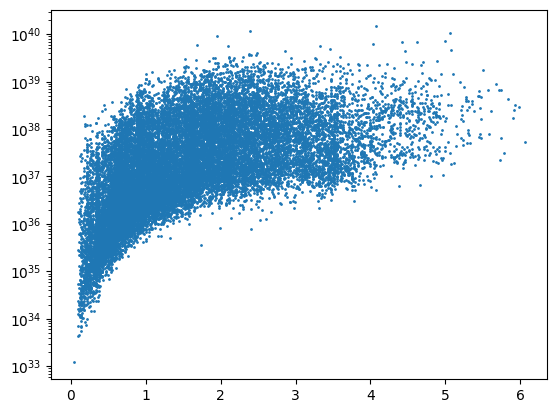

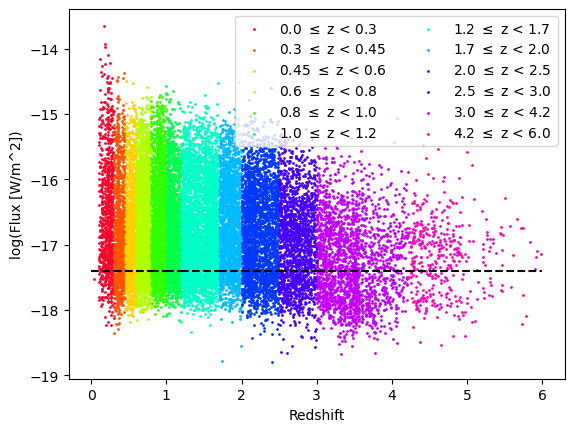

Flux limits: [3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18, 3.89e-18]
Galaxies: 17649
1.6195024687558732e+25 1.979312150152775e+27
5.233610773916106e+25 2.565293960245548e+27
8.530500296414878e+25 2.790895469214574e+27
1.1502036672218833e+26 3.7654250105062747e+27
1.61942101321366e+26 4.860434295957818e+27
2.1214528612143212e+26 5.659834082846249e+27
2.6806666443549146e+26 1.1046223113108177e+28
4.121526793062009e+26 1.3531194303826564e+28
5.0525790000820696e+26 1.5622924156669182e+28
6.569830370099618e+26 9.417950643724578e+27
8.135545662146522e+26 1.724354318279141e+28
1.2659259986300792e+27 1.4569733698668583e+28


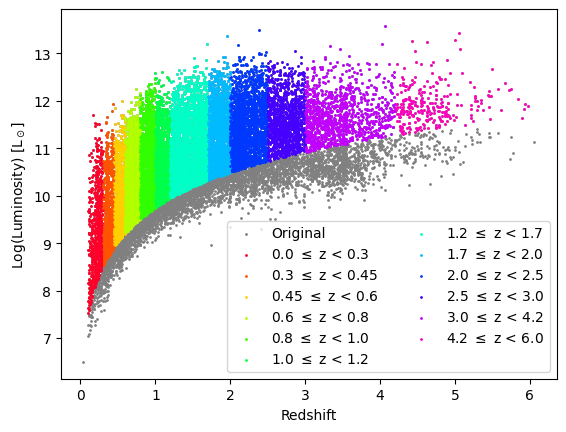

In [88]:
# Extracting data
z = odf['bayes.universe.redshift'].copy() # redshift
d_L = odf['bayes.universe.luminosity_distance'].copy() # M

F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2

# Mask outliers
mask_f = F_bol < 10**-10 # 114 sources with flux ~10^-5 !!!
luminosity = luminosity[mask_f]
old_luminosity = luminosity.copy()
z = z[mask_f]
old_z = z.copy()
d_L = d_L[mask_f]
F_bol = F_bol[mask_f]
print(f'Galaxies: {len(luminosity)}')

plt.scatter(z, luminosity, s=1)
plt.yscale('log')
plt.show()

F_lims = []
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))
for (z_start, z_end), perc, c in zip(redshift_bins, percentiles, colors):
    mask_z = (z >= z_start) & (z < z_end)
    # p = np.percentile(F_bol[mask_z], perc) # % of the data above perc
    p = 3.89e-18
    F_lims.append(p)
    mask_f = F_bol <= p
    luminosity[mask_f & mask_z] = 0 # remove galaxies with flux below p
    plt.scatter(z[mask_z], np.log10(F_bol[mask_z]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
    plt.hlines(np.log10(p), z_start, z_end, color='black', linestyle='--')
plt.ylabel('log(Flux [W/m^2])')
plt.xlabel('Redshift')
plt.legend(ncols=2)
plt.show()
print(f'Flux limits: {F_lims}')

# Remove galaxies with no luminosity
mask_l = luminosity > 0
luminosity = luminosity[mask_l]
z = z[mask_l]
d_L = d_L[mask_l]
print(f'Galaxies: {len(luminosity)}')

# Maximum distance of galaxies (eq 2)
dmaxs = np.zeros(len(luminosity))
for (z_start, z_end), F_lim in zip(redshift_bins, F_lims):
    mask_z = (z >= z_start) & (z < z_end)
    dmaxs[mask_z] = np.sqrt(luminosity[mask_z] / (4 * np.pi * F_lim))
    print(min(dmaxs[mask_z]), max(dmaxs[mask_z]))

mask_d = dmaxs > 0
luminosity = luminosity[mask_d]
z = z[mask_d]
dmaxs = dmaxs[mask_d]
d_L = d_L[mask_d]

zmaxs = z_at_value(cosmo.luminosity_distance, dmaxs * u.m)

luminosity *= 2.612*10**-27 # W -> solar luminosity
old_luminosity *= 2.612*10**-27 # W -> solar luminosity

plt.scatter(old_z, np.log10(old_luminosity), s=1, color='grey', label='Original')
for (z_start, z_end), c in zip(redshift_bins, colors):
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask_z], np.log10(luminosity[mask_z]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Redshift')
plt.ylabel('Log(Luminosity) [L$_\odot$]')
plt.legend(ncols=2)
plt.show()

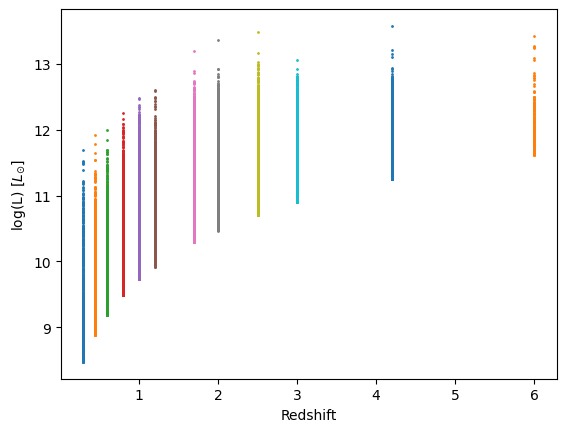

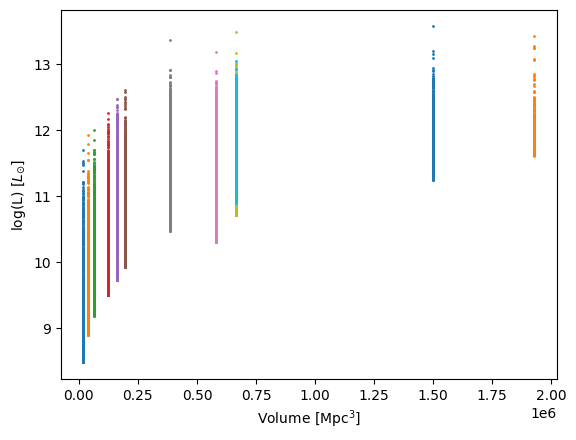

In [89]:
all_data = []
for z_start, z_end in redshift_bins:
    
    # Mask redshift
    mask_z = (z >= z_start) & (z < z_end)

    # Mask maximum redshift to the end of the redshift bin
    bin_zmaxs = zmaxs[mask_z]
    bin_zmaxs[bin_zmaxs > z_end] = z_end
    
    # Mask minimum redshift to end of the redshift bin
    mask_d = (bin_zmaxs == max(bin_zmaxs))
    bin_zmaxs = bin_zmaxs[mask_d]

    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmaxs = cosmo.comoving_distance(bin_zmaxs).value # Mpc
    
    # Calculate the minimum & maximum volume -
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3 - of the redshift bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3 - of each galaxy
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    # Save data
    all_data.append([vol, np.log10(luminosity[mask_z][mask_d])])

    # Plot maximum data
    plt.scatter(bin_zmaxs, np.log10(luminosity[mask_z][mask_d]), s=1)
    
plt.ylabel('log(L) $[L_{\odot}]$')
plt.xlabel('Redshift')
plt.show()

for vol, lum in all_data:
    plt.scatter(vol, lum, s=1)
plt.ylabel('log(L) $[L_{\odot}]$')
plt.xlabel('Volume [Mpc$^3$]')
plt.show()

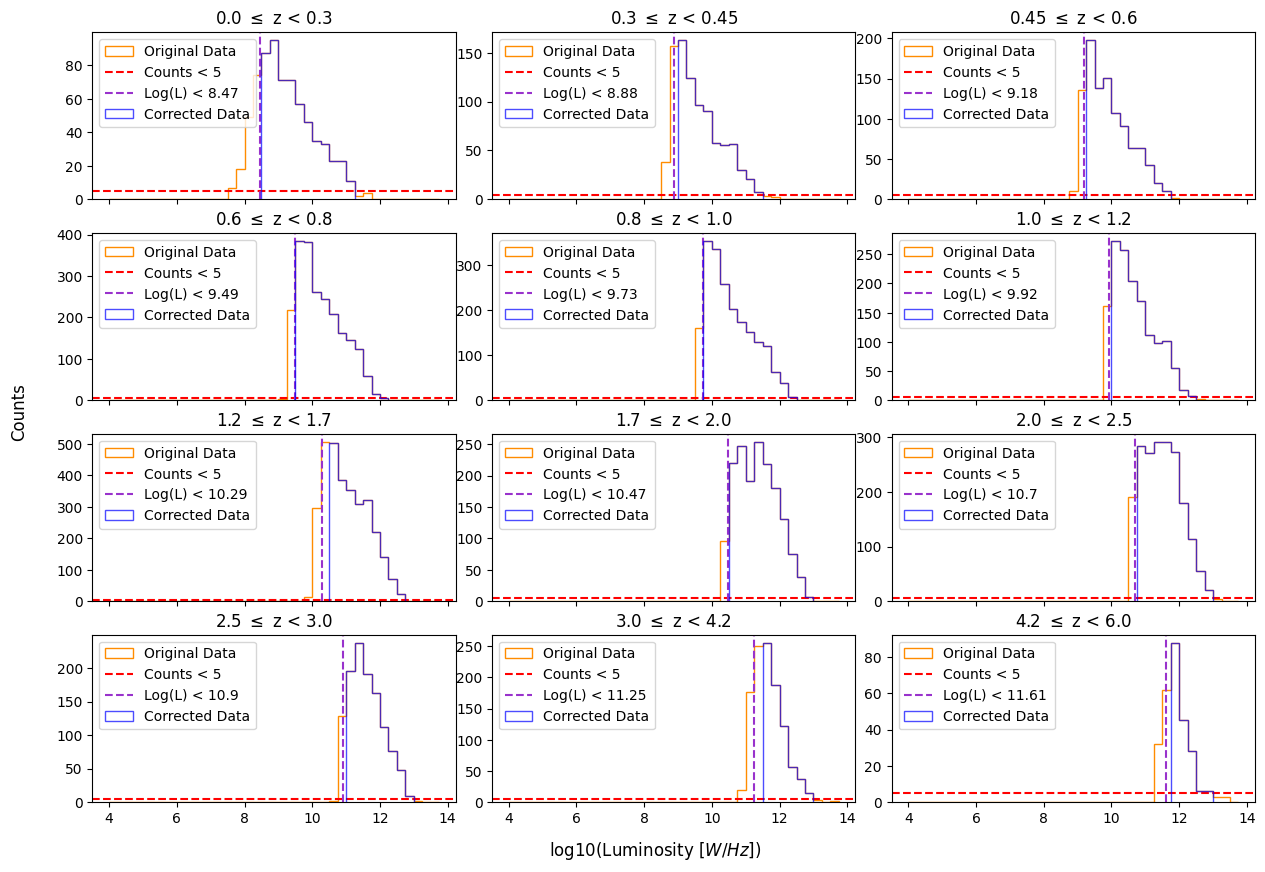

In [90]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
bin_edges = []
min_lums = []
for (z_start, z_end), (vol, lum), ax in zip(redshift_bins, all_data, axes.flatten()):
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity)[(z >= z_start) & (z < z_end)], bins=lum_bin_edges, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(min(lum), color='darkorchid', linestyle='--', label=f'Log(L) < {round(min(lum), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        bin_edges.append(b)
        min_lums.append(min(lum))
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)
    min_lums.append(min(lum))
    
fig.supylabel('Counts', x=0.07)
fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

0.0 <= z < 0.3, [8.625, 8.875, 9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125]
0.3 <= z < 0.45, [9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375]
0.45 <= z < 0.6, [9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625]
0.6 <= z < 0.8, [9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125]
0.8 <= z < 1.0, [9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375]
1.0 <= z < 1.2, [10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375]
1.2 <= z < 1.7, [10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625]
1.7 <= z < 2.0, [10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625, 12.875]
2.0 <= z < 2.5, [10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625, 12.875]
2.5 <= z < 3.0, [11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625, 12.875]
3.0 <= z < 4.2, [11.625, 11.875, 12.125, 12.375, 12.

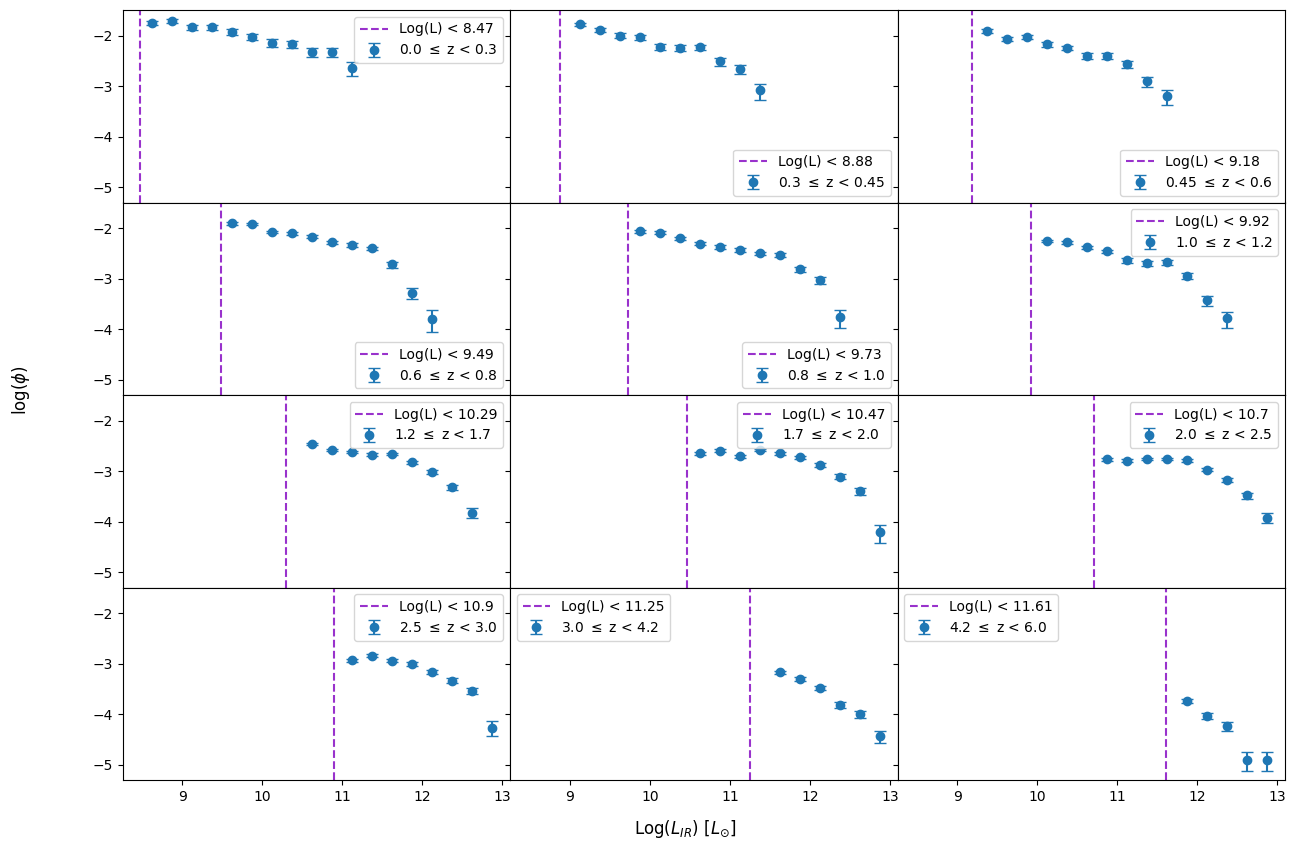

In [91]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin in zip(all_data, bin_edges):
    
    if len(bin) <= 1:
        lum_centers.append(np.array([]))
        phi.append(np.array([]))
        phi_e.append(np.array([]))
        continue
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_ls in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), min_lums):
    print(f'{z_start} <= z < {z_end}, {(lum)}')
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(min_ls, color='darkorchid', linestyle='--', label=f'Log(L) < {round(min_ls, 2)}')
    ax.legend()
    
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

0.0 <= z < 0.3 Function fit:
Log L_star = 11.07 +/- 0.17
Log phi_star = -2.2 +/- 0.04
Alpha = 1.2


0.3 <= z < 0.45 Function fit:
Log L_star = 11.0 +/- 0.18
Log phi_star = -2.2 +/- 0.05
Alpha = 1.2


0.45 <= z < 0.6 Function fit:
Log L_star = 11.23 +/- 0.15
Log phi_star = -2.32 +/- 0.04
Alpha = 1.2


0.6 <= z < 0.8 Function fit:
Log L_star = 11.64 +/- 0.0
Log phi_star = -2.31 +/- 0.01
Alpha = 1.2


0.8 <= z < 1.0 Function fit:
Log L_star = 11.99 +/- 0.0
Log phi_star = -2.5 +/- 0.01
Alpha = 1.2


1.0 <= z < 1.2 Function fit:
Log L_star = 11.89 +/- 0.0
Log phi_star = -2.6 +/- 0.02
Alpha = 1.2


1.2 <= z < 1.7 Function fit:
Log L_star = 12.4 +/- 0.0
Log phi_star = -2.83 +/- 0.02
Alpha = 1.2


1.7 <= z < 2.0 Function fit:
Log L_star = 12.78 +/- 0.0
Log phi_star = -2.96 +/- 0.03
Alpha = 1.2


2.0 <= z < 2.5 Function fit:
Log L_star = 12.81 +/- 0.0
Log phi_star = -3.06 +/- 0.03
Alpha = 1.2


2.5 <= z < 3.0 Function fit:
Log L_star = 12.65 +/- 0.0
Log phi_star = -3.13 +/- 0.03
Alpha = 1.2


3

C:\Users\n10480129\AppData\Local\Temp\ipykernel_10544\3812606191.py:56: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_10544\3812606191.py:58: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_down)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_10544\3812606191.py:59: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_up)),


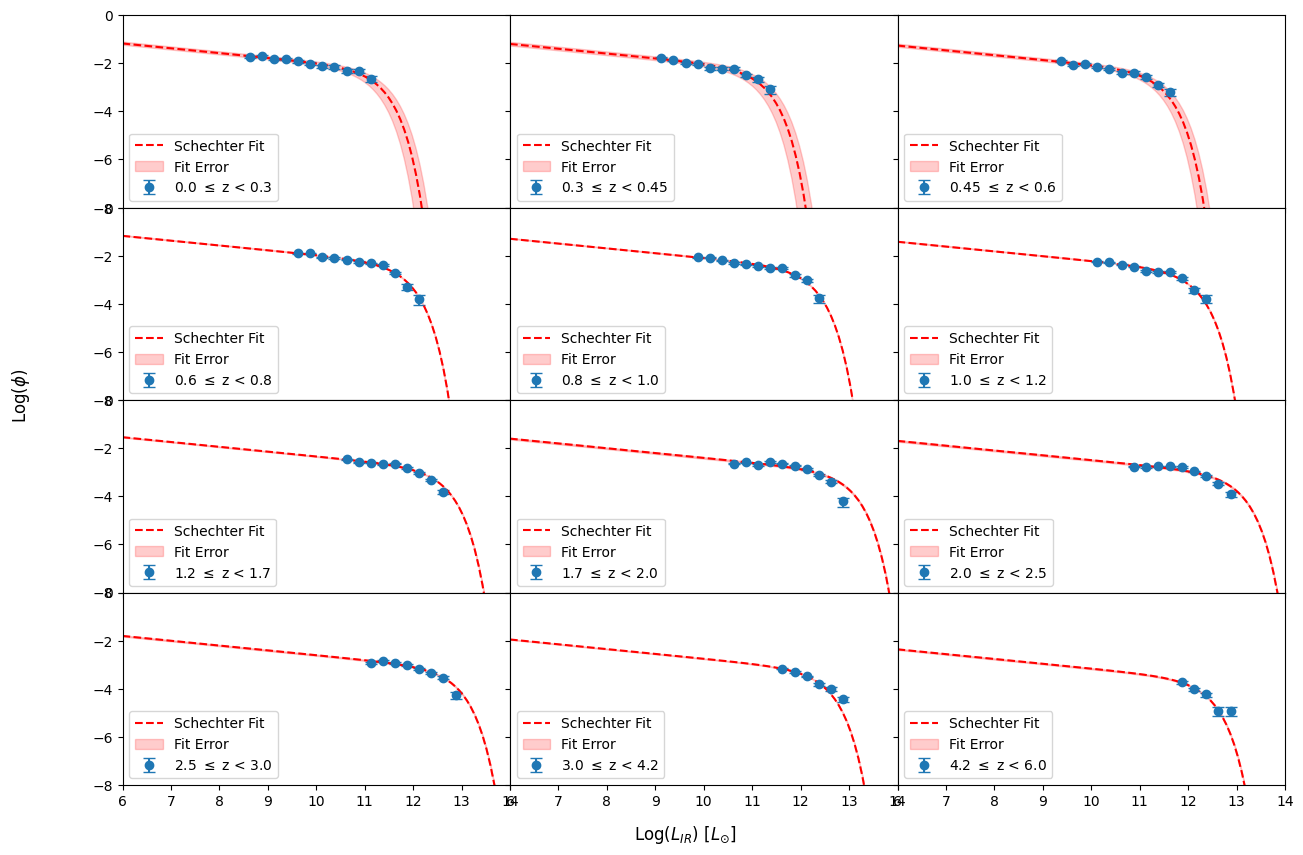

In [92]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []
schechter_funcs = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        schecter_params.append(params)
        schecter_errors.append(perr)
        schechter_funcs.append(schechter_luminosity)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        schecter_params.append([])
        schecter_errors.append([])
        schechter_funcs.append(None)
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        schecter_params.append([])
        schecter_errors.append([])
        schechter_funcs.append(None)
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.2')
    
    if len(params) == 3:
        print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(6, 14, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-8, 0)
    ax.set_xlim(6, 14)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

0.0 <= z < 0.3 Function fit:
Log L_star = 10.78 +/- nan
Log phi_star = -2.32 +/- 0.22
Alpha = 1.3
Sigma = 0.7


0.3 <= z < 0.45 Function fit:
Log L_star = 10.42 +/- 0.23
Log phi_star = -2.19 +/- 0.07
Alpha = 1.3
Sigma = 0.7


0.45 <= z < 0.6 Function fit:
Log L_star = 10.64 +/- 0.23
Log phi_star = -2.3 +/- 0.07
Alpha = 1.3
Sigma = 0.7


0.6 <= z < 0.8 Function fit:
Log L_star = 11.06 +/- 0.23
Log phi_star = -2.31 +/- 0.06
Alpha = 1.3
Sigma = 0.7


0.8 <= z < 1.0 Function fit:
Log L_star = 11.45 +/- 0.0
Log phi_star = -2.52 +/- 0.01
Alpha = 1.3
Sigma = 0.9


1.0 <= z < 1.2 Function fit:
Log L_star = 11.26 +/- 0.0
Log phi_star = -2.57 +/- 0.01
Alpha = 1.3
Sigma = 0.7


1.2 <= z < 1.7 Function fit:
Log L_star = 11.79 +/- 0.0
Log phi_star = -2.8 +/- 0.02
Alpha = 1.3
Sigma = 0.9


1.7 <= z < 2.0 Function fit:
Log L_star = 12.2 +/- 0.0
Log phi_star = -2.98 +/- 0.05
Alpha = 1.3
Sigma = 0.9


2.0 <= z < 2.5 Function fit:
Log L_star = 12.21 +/- 0.0
Log phi_star = -3.05 +/- 0.04
Alpha = 1.3
Sigm

C:\Users\n10480129\AppData\Local\Temp\ipykernel_10544\2726288756.py:45: RuntimeWarning: invalid value encountered in log10
  print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')


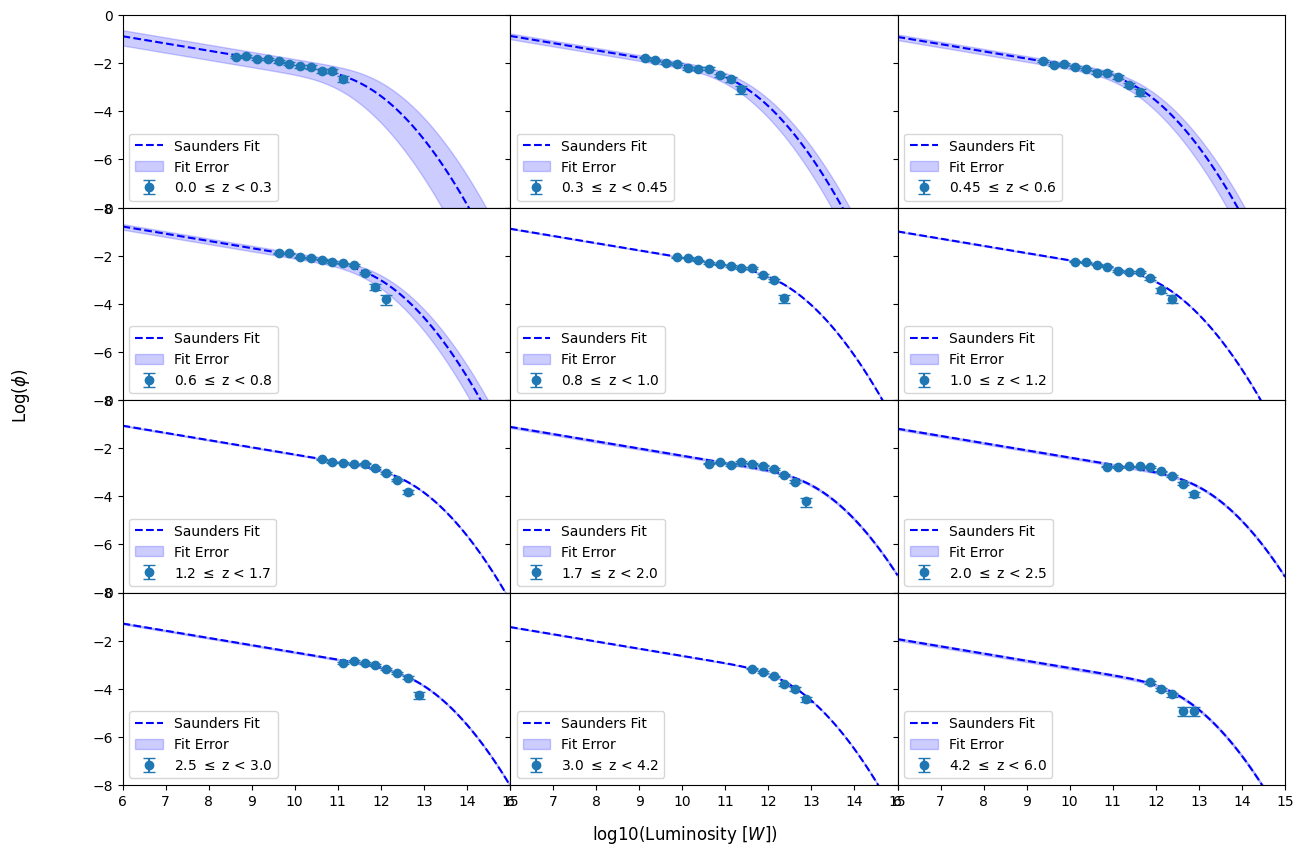

In [93]:
def saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
saunder_funcs = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    lum = np.power(10, lum)
    
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(saunders_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        saunder_params.append(params)
        saunder_error.append(perr)
        saunder_funcs.append(saunders_luminosity)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        saunder_params.append([])
        saunder_error.append([])
        saunder_funcs.append(None)
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        saunder_params.append([])
        saunder_error.append([])
        saunder_funcs.append(None)
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.3')
    
    if z_start in [0.8, 1.2, 1.7]:
        print(f'Sigma = 0.9')
    else:
        print(f'Sigma = 0.7')
    
    if len(params) > 2:
        print(f'alpha = {params[2]:.2e} +/- {perr[2]:.2e}')
    if len(params) > 3:
        print(f'sigma = {params[3]:.2e} +/- {perr[3]:.2e}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(6, 15, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *p_down)), 
        np.log10(saunders_luminosity(long_lum, *p_up)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-8, 0)
    ax.set_xlim(6, 15)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# Schechter Function
for i, (ax, func, params, perr) in enumerate(zip(axes.flatten(), schechter_funcs, schecter_params, schecter_errors)):
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='red', label='Schechter Fit' if i == 0 else "", linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(func(long_lum, *p_down)),
        np.log10(func(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error' if i == 1 else "")

# Saunders Function
for i, (ax, func, params, perr) in enumerate(zip(axes.flatten(), saunder_funcs, saunder_params, saunder_error)):
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='blue', label='Saunders Fit' if i == 0 else "", linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(func(long_lum, *p_down)),
        np.log10(func(long_lum, *p_up)),
        color='blue', alpha=0.2, label='Fit Error' if i == 1 else "")

# Luminosity Function
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='red', label='Schechter' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='blue', label='Saunders' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)
ax[0].set_ylim(10**7.5, 10**13)
ax[1].set_ylim(10**-5, 10**-1.5)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_centers = np.arange(8.5, 13.5, 0.5) # luminosity bin edges
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_centers)))

# Iterate over the luminosity bins
est_phi = []
est_phi_e = []
new_z = []
for l_center in luminosity_centers:
    est_phi_z = []
    est_phi_e_z = []
    new_z_z = []

    # Iterate over the redshift bins:
    for z_val, params, perr in zip(redshift_centers, saunder_params, saunder_error):
        if len(params) == 0:
            continue
    
        # Calculate the number density of the missing luminosity bin
        est_phi_z.append(saunders_luminosity(10**l_center, *params))
        est_phi_e_z.append([saunders_luminosity(10**l_center, *(params - perr)), saunders_luminosity(10**l_center, *(params + perr))])
        new_z_z.append(z_val)
            
    est_phi.append(est_phi_z)
    est_phi_e.append(est_phi_e_z)
    new_z.append(new_z_z)
    
# Plot the estimated number densities
for nz, nphi, lcent, c, nphie in zip(new_z, est_phi, luminosity_centers, colors, est_phi_e):
    nphie = np.array(nphie).T
    nphi = np.array(nphi)
    yerr = [np.log10(nphi) - np.log10(nphi - nphie[0]), np.log10(nphi + nphie[1]) - np.log10(nphi)]
    plt.errorbar(nz, np.log10(nphi), yerr=np.abs(yerr), capsize=4, color=c, label=f'{lcent}', linestyle='--', marker='x')
    
plt.legend(ncols=2)
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([-8, -6, -4, -2], fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
file_name = 'fits/cigale_AGN'
np.savez(file_name, 
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object), 
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(min_lums, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object),
    schech_f=np.array(schechter_funcs, dtype=object),
    saunder_f=np.array(saunder_funcs, dtype=object))